# Algorithmic Trading with Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
import yfinance as yf
import pandas_datareader as pdr
import tensorflow as tf

In [2]:
tickers_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers_data = tickers_data.rename(columns={'Symbol':'Ticker',
                                            'GICS Sector': 'Sector'})
tickers_data.loc[:,'Ticker'] = tickers_data.loc[:,'Ticker'].apply(lambda x:str(x).replace('.', '-' ))
tickers_data.head()

,Ticker,Security,Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
start = '2000-01-01'
end = '2020-01-01'

In [4]:
tickers = yf.Tickers(list(tickers_data.loc[:,'Ticker']))

data = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
data = data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)
data['Date'] = data.index
data = data.reset_index(drop=True)
data.head()

[*********************100%%**********************]  503 of 503 completed


7 Failed downloads:
['VLTO', 'GEHC', 'OTIS', 'KVUE', 'ABNB', 'CEG', 'CARR']: Exception("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1577854800")


,Ticker,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume,Date
0,A,43.757755,51.502148,0.0,56.464592,48.193848,56.330471,0.0,4674353.0,2000-01-03
1,AAPL,0.847207,0.999442,0.0,1.004464,0.907924,0.936384,0.0,535796800.0,2000-01-03
2,ABT,9.081104,15.711531,0.0,16.160433,15.599306,15.823756,0.0,10635087.0,2000-01-03
3,ACGL,1.277778,1.277778,0.0,1.416667,1.263889,1.409722,0.0,433800.0,2000-01-03
4,ADBE,16.274675,16.390625,0.0,16.875000,16.062500,16.812500,0.0,7384400.0,2000-01-03


In [5]:
_open = data.pivot(index='Date', columns='Ticker', values='Open')
_open = _open.dropna(axis=1)
_open.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,56.330471,0.936384,15.823756,1.409722,16.812500,46.7500,10.884354,42.428928,8.500000,32.5625,...,68.375,1.887517,7.71875,71.0625,19.6250,39.75000,7.958333,6.930715,25.930555,59.03125
2000-01-04,48.730328,0.966518,15.459024,1.263889,15.750000,44.7500,10.714286,40.941933,8.046875,32.3125,...,65.500,1.854595,7.68750,69.7500,19.0625,38.68750,7.833333,6.649892,25.027779,54.62500
2000-01-05,47.389126,0.926339,15.066236,1.284722,14.562500,42.8125,10.770975,41.189766,7.750000,32.3125,...,63.875,1.711934,7.65625,67.2500,19.4375,39.00000,7.833333,6.604960,23.569445,52.75000
2000-01-06,44.080830,0.947545,15.262630,1.388889,15.359375,43.4375,10.544218,41.140202,7.375000,33.5625,...,63.000,1.733882,7.62500,71.1875,20.1250,40.31250,7.875000,6.560029,24.819445,52.75000
2000-01-07,42.247852,0.861607,15.487080,1.375000,15.390625,42.0000,10.770975,42.329796,7.015625,33.5000,...,64.500,1.733882,7.53125,72.0625,20.0000,42.96875,7.958333,6.548796,23.666668,53.75000


In [6]:
_adj_close = data.pivot(index='Date', columns='Ticker', values='Adj Close')
_adj_close = _adj_close.dropna(axis=1)
_adj_close.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.757755,0.847207,9.081104,1.277778,16.274675,28.572309,6.473892,24.924683,8.052906,10.770645,...,43.555939,1.227682,5.431209,11.621565,7.112460,18.499039,6.695475,4.703720,25.027779,36.146156
2000-01-04,40.415150,0.775779,8.821650,1.270833,14.909402,27.126854,6.406459,24.924683,7.660816,10.770645,...,41.926159,1.189908,5.487315,11.184971,7.276231,18.144712,6.695475,4.609172,24.666668,34.395851
2000-01-05,37.908188,0.787131,8.805431,1.388889,15.204173,27.522861,6.305305,24.685009,7.178246,11.187301,...,41.070511,1.171020,5.464871,11.777485,7.556986,19.133873,6.811220,4.632810,25.138889,34.355114
2000-01-06,36.464787,0.719014,9.113544,1.375000,15.328291,26.770439,6.339020,25.014547,6.740914,11.145637,...,41.518703,1.239015,5.408763,12.328423,7.486801,20.123056,6.820124,4.593416,23.777779,34.843594
2000-01-07,39.503525,0.753073,9.210839,1.451389,16.072985,27.522861,6.440176,25.583742,7.540175,11.312298,...,44.656036,1.220127,5.464871,11.923016,7.486801,20.063993,6.802318,4.490988,23.513889,34.924992


-----

In [6]:
tickers.tickers['AAPL'].info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

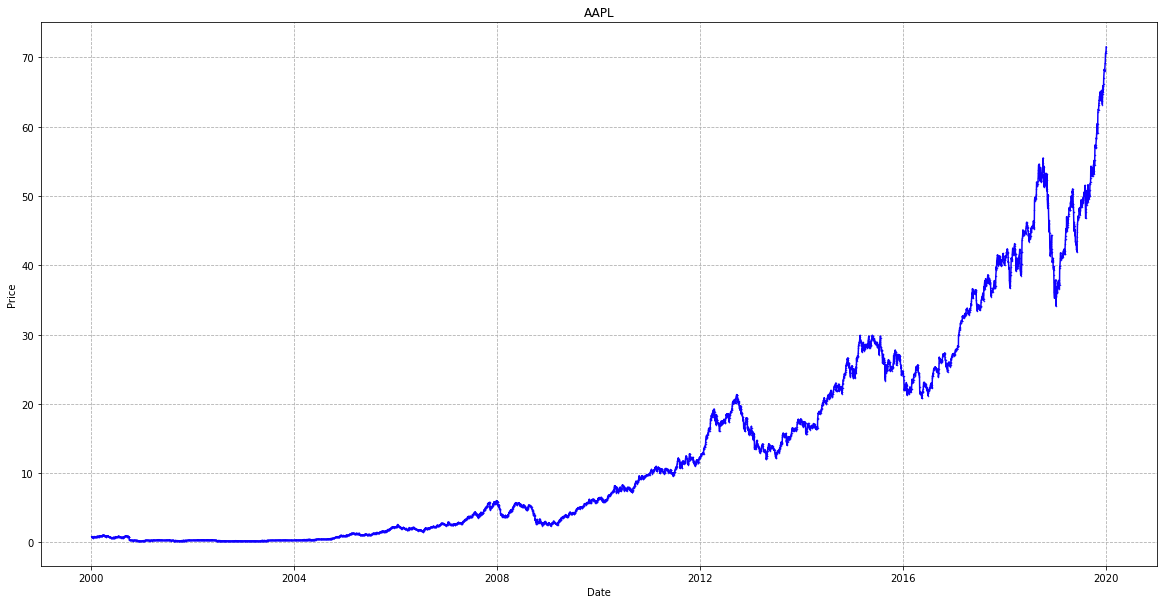

In [7]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('AAPL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.plot(_adj_close.index, _adj_close.loc[:,['AAPL']].values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

-----

In [8]:
pdr.famafrench.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [9]:
ff = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily', start=start, end=end).read()[0]
ff.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2000-01-03,-0.71,0.62,-1.41,0.021
2000-01-04,-4.06,0.00,2.06,0.021
2000-01-05,-0.09,0.20,0.16,0.021
2000-01-06,-0.73,-0.43,1.26,0.021
2000-01-07,3.21,-0.48,-1.42,0.021


In [10]:
m = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily', start=start, end=end).read()[0]
m.head()

,Mom
Date,
2000-01-03,-0.08
2000-01-04,-1.91
2000-01-05,-0.49
2000-01-06,-1.49
2000-01-07,0.56


In [11]:
factors = pd.merge(ff, m, how='inner', on='Date')
factors = factors.drop('RF', axis=1)
factors.head()

,Mkt-RF,SMB,HML,Mom
Date,,,,
2000-01-03,-0.71,0.62,-1.41,-0.08
2000-01-04,-4.06,0.00,2.06,-1.91
2000-01-05,-0.09,0.20,0.16,-0.49
2000-01-06,-0.73,-0.43,1.26,-1.49
2000-01-07,3.21,-0.48,-1.42,0.56


-----

In [12]:
returns = ((_adj_close - _adj_close.shift(1))/_adj_close.shift(1)).iloc[1:,:]
returns.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.076389,-0.084310,-0.028571,-0.005435,-0.083889,-0.050589,-0.010416,0.000000,-0.048689,0.000000,...,-0.037418,-0.030769,0.010330,-0.037568,0.023026,-0.019154,0.000000,-0.020101,-0.014428,-0.048423
2000-01-05,-0.062030,0.014633,-0.001838,0.092897,0.019771,0.014598,-0.015789,-0.009616,-0.062992,0.038684,...,-0.020408,-0.015873,-0.004090,0.052974,0.038585,0.054515,0.017287,0.005128,0.019144,-0.001184
2000-01-06,-0.038076,-0.086538,0.034991,-0.010000,0.008163,-0.027338,0.005347,0.013350,-0.060925,-0.003724,...,0.010913,0.058065,-0.010267,0.046779,-0.009288,0.051698,0.001307,-0.008503,-0.054144,0.014219
2000-01-07,0.083333,0.047369,0.010676,0.055556,0.048583,0.028106,0.015958,0.022755,0.118569,0.014953,...,0.075564,-0.015244,0.010374,-0.032884,0.000000,-0.002935,-0.002611,-0.022299,-0.011098,0.002336
2000-01-10,0.060577,-0.017588,-0.007042,0.033493,0.038610,0.087051,0.000000,0.024590,-0.010100,-0.007366,...,-0.018248,-0.009288,0.020534,-0.004359,0.000000,-0.013980,0.023560,0.040351,0.033668,-0.018066


-----

In [13]:
F = factors.loc[returns.index,:]
R = returns.sub(ff.loc[returns.index,'RF'], axis=0) 

In [14]:
split_date = '2016-01-01'

F_train = F.loc[:split_date,:].values
R_train = R.loc[:split_date,:].values

F_test = F.loc[split_date:,:].values
R_test = R.loc[split_date:,:].values

In [15]:
def Model():
    model = tf.keras.models.Sequential([
         tf.keras.layers.Dense(units=R_train.shape[1],
                               activation='linear',
                               kernel_initializer='glorot_uniform',
                               use_bias=False,
                               input_shape=[F_train.shape[1]])
     ])
    
    loss = tf.keras.losses.MeanSquaredError()
    metric = tf.keras.metrics.MeanAbsoluteError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)
    model.compile(loss=loss, 
                  metrics=[metric], 
                  optimizer=optimizer)
    model.summary()
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     patience=100,
                                                     min_delta=0.001,
                                                     factor=0.1, 
                                                     min_lr=0.00001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=200,
                                                 min_delta=0.00001)
    model.fit(F_train, 
              R_train, 
              epochs=10000, 
              batch_size=64, 
              callbacks=[callback1, callback2], 
              verbose=True)
    return model

In [16]:
model = Model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 361)               1444      
                                                                 
Total params: 1,444
Trainable params: 1,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
63/63 [==============================] - 0s 474us/step - loss: 0.0109 - mean_absolute_error: 0.0650 - lr: 0.0010
Epoch 2/10000
 1/63 [..............................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0492

2023-12-21 03:14:22.141812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 0s 472us/step - loss: 0.0027 - mean_absolute_error: 0.0327 - lr: 0.0010
Epoch 3/10000
63/63 [==============================] - 0s 461us/step - loss: 8.8424e-04 - mean_absolute_error: 0.0196 - lr: 0.0010
Epoch 4/10000
63/63 [==============================] - 0s 437us/step - loss: 5.3964e-04 - mean_absolute_error: 0.0155 - lr: 0.0010
Epoch 5/10000
63/63 [==============================] - 0s 432us/step - loss: 4.8208e-04 - mean_absolute_error: 0.0146 - lr: 0.0010
Epoch 6/10000
63/63 [==============================] - 0s 434us/step - loss: 4.7329e-04 - mean_absolute_error: 0.0144 - lr: 0.0010
Epoch 7/10000
63/63 [==============================] - 0s 430us/step - loss: 4.7202e-04 - mean_absolute_error: 0.0144 - lr: 0.0010
Epoch 8/10000
63/63 [==============================] - 0s 438us/step - loss: 4.7129e-04 - mean_absolute_error: 0.0144 - lr: 0.0010
Epoch 9/10000
63/63 [==============================] - 0s 437us/step - loss: 4.7187e-04 - mean_absolu

63/63 [==============================] - 0s 431us/step - loss: 4.7597e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 65/10000
63/63 [==============================] - 0s 426us/step - loss: 4.7552e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 66/10000
63/63 [==============================] - 0s 427us/step - loss: 4.7595e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 67/10000
63/63 [==============================] - 0s 429us/step - loss: 4.7646e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 68/10000
63/63 [==============================] - 0s 416us/step - loss: 4.7535e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 69/10000
63/63 [==============================] - 0s 433us/step - loss: 4.7556e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 70/10000
63/63 [==============================] - 0s 423us/step - loss: 4.7581e-04 - mean_absolute_error: 0.0145 - lr: 0.0010
Epoch 71/10000
63/63 [==============================] - 0s 439us/step - loss: 4.7599e-04 - 

63/63 [==============================] - 0s 420us/step - loss: 4.7004e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 126/10000
63/63 [==============================] - 0s 427us/step - loss: 4.7000e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 127/10000
63/63 [==============================] - 0s 425us/step - loss: 4.7002e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 128/10000
63/63 [==============================] - 0s 430us/step - loss: 4.6999e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 129/10000
63/63 [==============================] - 0s 432us/step - loss: 4.6996e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 130/10000
63/63 [==============================] - 0s 414us/step - loss: 4.7020e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 131/10000
63/63 [==============================] - 0s 416us/step - loss: 4.7001e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 132/10000
63/63 [==============================] - 

Epoch 185/10000
63/63 [==============================] - 0s 436us/step - loss: 4.7006e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 186/10000
63/63 [==============================] - 0s 420us/step - loss: 4.7007e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 187/10000
63/63 [==============================] - 0s 413us/step - loss: 4.7013e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 188/10000
63/63 [==============================] - 0s 427us/step - loss: 4.7000e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 189/10000
63/63 [==============================] - 0s 435us/step - loss: 4.6997e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 190/10000
63/63 [==============================] - 0s 412us/step - loss: 4.7006e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 191/10000
63/63 [==============================] - 0s 414us/step - loss: 4.7009e-04 - mean_absolute_error: 0.0144 - lr: 1.0000e-04
Epoch 192/10000
63/63 [==================

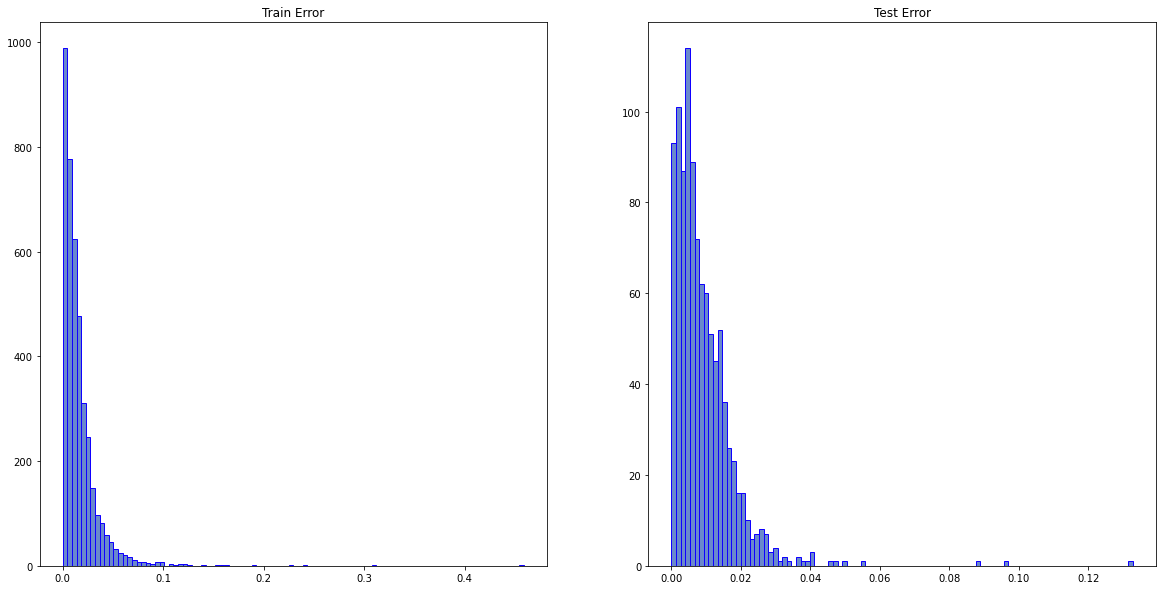

In [17]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Train Error')
_ = ax1.hist(np.abs(R_train - model.predict(F_train))[:,[0]], bins=100, color='#6A89CC', edgecolor='#0F00FF')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Test Error')
_ = ax2.hist(np.abs(R_test - model.predict(F_test))[:,[0]], bins=100, color='#6A89CC', edgecolor='#0F00FF')

In [40]:
model.save_weights('ml_algorithmic_trading')

-----

In [20]:
mae = np.mean(np.abs(R_train-model.predict(F_train)), axis=0)
std = np.std(np.abs(R_train-model.predict(F_train)), axis=0)

In [21]:
signals = pd.DataFrame(np.sign(1.+np.sign(np.abs(R_test-model.predict(F_test)) - (mae + 2*std))), 
                       columns=R.loc[split_date:,:].columns, 
                       index=R.loc[split_date:,:].index)

signals.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
signals.sum(axis=1).mean()

4.6958250497017895

-----

In [23]:
def trading_signals(signals, bottom_threshold, top_threshold):
    filtered_signals = pd.DataFrame(np.zeros(shape=signals.shape))
    filtered_signals = filtered_signals.set_index(signals.index)
    filtered_signals.columns = signals.columns
    for i in range(signals.shape[0]):
        t = signals.iloc[i,:].sum()
        if t<top_threshold and t>bottom_threshold:  
            filtered_signals.iloc[i,:] = signals.iloc[i,:]  
        else:
            filtered_signals.iloc[i,:] = np.array(filtered_signals.shape[1]*[np.nan])
    filtered_signals = filtered_signals.dropna(axis=0)
    return filtered_signals

In [24]:
bottom_threshold = 10
top_threshold = 30
signals = trading_signals(signals=signals, 
                          bottom_threshold=bottom_threshold, 
                          top_threshold=top_threshold)
signals.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


-----

In [25]:
def optimal_portfolio(u, V, x0, risk_tolerance, turnover):
    x = cvx.Variable(u.shape[0])
    f = cvx.quad_form(x, V) - risk_tolerance*u@x + turnover*cvx.norm(x-x0, p=1) 
    prob = cvx.Problem(cvx.Minimize(f), 
                      [cvx.sum(x) == 1])
    prob.solve(solver=cvx.ECOS)
    return x.value

In [26]:
def trading_strategy(signals, returns, trading_window_length, risk_tolerance, turnover):
    portfolio_positions = pd.DataFrame(np.zeros(shape=signals.shape))
    portfolio_positions = portfolio_positions.set_index(signals.index)
    portfolio_positions.columns = signals.columns
    for i in range(signals.shape[0]):
        date = signals.index[i]
        tickers = signals.iloc[i,:].apply(lambda x:np.nan if x==0. else x).dropna().index            
        r = returns.loc[:date,:].iloc[-trading_window_length:,:].loc[:,tickers].values
        u = np.mean(r, axis=0)
        V = np.cov(r.T)  
        if i==0:
            x0 = np.ones(tickers.shape[0])/tickers.shape[0]
        else:
            x0 = portfolio_positions.iloc[i-1,:].loc[tickers].values
        x = optimal_portfolio(u, V, x0, risk_tolerance, turnover)
        if x is not None:
            portfolio_positions.loc[date,tickers] = x
        else:
            portfolio_positions.loc[date,:] = np.array(portfolio_positions.shape[1]*[np.nan])
    portfolio_positions = portfolio_positions.dropna(axis=0)
    return portfolio_positions

In [27]:
trading_window_length = 30
risk_tolerance = 1.
turnover = 1.

portfolio_positions = trading_strategy(signals=signals, 
                                       returns=returns, 
                                       trading_window_length=trading_window_length,
                                       risk_tolerance=risk_tolerance,
                                       turnover=turnover)
portfolio_positions.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2016-01-21,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2016-01-25,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2016-01-28,0.0,0.0,4.006459e-11,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2016-02-03,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,5.644099e-11,0.0,...,0.0,0.0,0.0,0.0,0.0,5.648501e-11,0.0,0.0,0.0,0.0


In [28]:
portfolio_positions.shape[0], np.sum(portfolio_positions.values)

(89, 88.99999999266586)

-----

In [29]:
trading_prices = _open.shift(-1).loc[portfolio_positions.index,:]
trading_prices.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,38.430000,25.137501,40.990002,22.850000,89.889999,51.549999,34.560001,78.860001,55.509998,43.639999,...,64.379997,22.946667,55.540001,27.930000,36.610001,74.120003,56.099998,49.295471,59.570000,24.420000
2016-01-21,37.910000,24.657499,40.200001,21.843332,89.550003,51.500000,32.520000,80.830002,48.639999,42.349998,...,62.439999,21.791111,57.150002,25.360001,36.310001,76.419998,56.820000,49.769951,56.610001,21.530001
2016-01-25,37.889999,24.982500,39.860001,22.093332,87.260002,51.340000,32.880001,80.089996,48.290001,42.759998,...,63.360001,21.391111,57.380001,24.670000,36.650002,74.769997,57.520000,48.835369,55.500000,20.740000
2016-01-28,36.439999,23.697500,36.689999,22.250000,85.550003,52.070000,34.860001,81.519997,45.720001,44.299999,...,64.750000,21.786667,55.119999,24.670000,37.540001,76.730003,58.230000,50.833931,56.110001,22.230000
2016-02-03,37.150002,23.965000,37.779999,22.083332,87.820000,51.209999,33.439999,82.029999,49.459999,47.160000,...,65.760002,22.377777,56.669998,25.389999,39.130001,78.580002,59.220001,51.739758,59.400002,21.740000


In [30]:
trading_returns = ((trading_prices - trading_prices.shift(1))/trading_prices.shift(1)).iloc[1:,:]
trading_returns.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-21,-0.013531,-0.019095,-0.019273,-0.044055,-0.003782,-0.000970,-0.059028,0.024981,-0.123761,-0.029560,...,-0.030134,-0.050358,0.028988,-0.092016,-0.008194,0.031031,0.012834,0.009625,-0.049689,-0.118346
2016-01-25,-0.000528,0.013181,-0.008458,0.011445,-0.025572,-0.003107,0.011070,-0.009155,-0.007196,0.009681,...,0.014734,-0.018356,0.004024,-0.027208,0.009364,-0.021591,0.012320,-0.018778,-0.019608,-0.036693
2016-01-28,-0.038269,-0.051436,-0.079528,0.007091,-0.019597,0.014219,0.060219,0.017855,-0.053220,0.036015,...,0.021938,0.018492,-0.039387,0.000000,0.024284,0.026214,0.012344,0.040924,0.010991,0.071842
2016-02-03,0.019484,0.011288,0.029708,-0.007491,0.026534,-0.016516,-0.040734,0.006256,0.081802,0.064560,...,0.015598,0.027132,0.028120,0.029185,0.042355,0.024110,0.017002,0.017819,0.058635,-0.022042
2016-02-04,0.002961,0.006885,0.011911,-0.000906,-0.026418,0.003710,0.025120,0.009387,-0.009705,-0.020780,...,0.016727,0.001589,-0.014646,0.008271,-0.005367,0.010435,0.002364,0.004724,0.023737,0.018859


In [31]:
portfolio_returns = np.sum(trading_returns*portfolio_positions.shift(1).iloc[1:,:], axis=1)
portfolio_returns

Date
2016-01-21   -0.004102
2016-01-25   -0.051394
2016-01-28    0.035398
2016-02-03    0.026184
2016-02-04   -0.009960
                ...   
2019-10-25    0.028453
2019-10-30   -0.014954
2019-11-04    0.024988
2019-11-05   -0.010585
2019-12-12    0.006626
Length: 88, dtype: float64

<AxesSubplot:title={'center':'Portfolio Returns'}, ylabel='Density'>

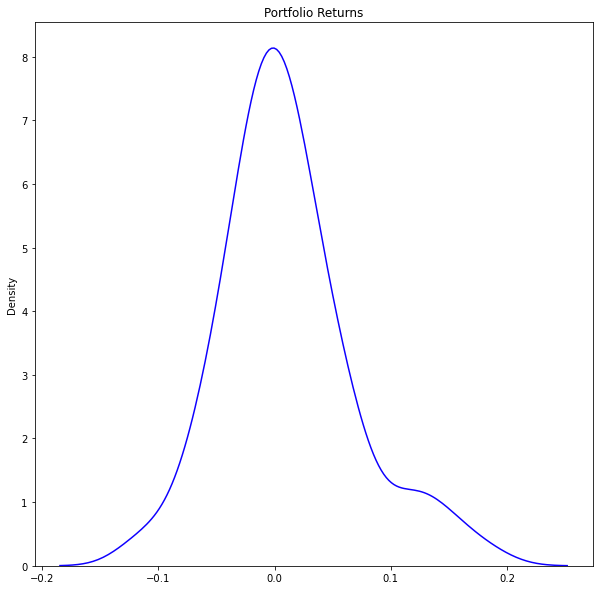

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Portfolio Returns')
sns.kdeplot(data=portfolio_returns, ax=ax, color='#0F00FF')

-----

In [33]:
discount_factor = np.cumprod(portfolio_returns+1)
discount_factor

Date
2016-01-21    0.995898
2016-01-25    0.944715
2016-01-28    0.978156
2016-02-03    1.003768
2016-02-04    0.993771
                ...   
2019-10-25    2.157520
2019-10-30    2.125256
2019-11-04    2.178362
2019-11-05    2.155305
2019-12-12    2.169587
Length: 88, dtype: float64

In [34]:
start = portfolio_positions.index[0]
end = portfolio_positions.index[-1]

In [35]:
market_portfolio_positions = _adj_close.loc[start:end,:].div(_adj_close.loc[start:end,:].sum(axis=1), axis=0)
market_trading_prices = _open.shift(-1).loc[market_portfolio_positions.index,:]
market_trading_returns = ((market_trading_prices - market_trading_prices.shift(1))/market_trading_prices.shift(1)).iloc[1:,:]
market_portfolio_returns = np.sum(market_trading_returns*market_portfolio_positions.shift(1).iloc[1:,:], axis=1)
market_discount_factor = np.cumprod(market_portfolio_returns+1)

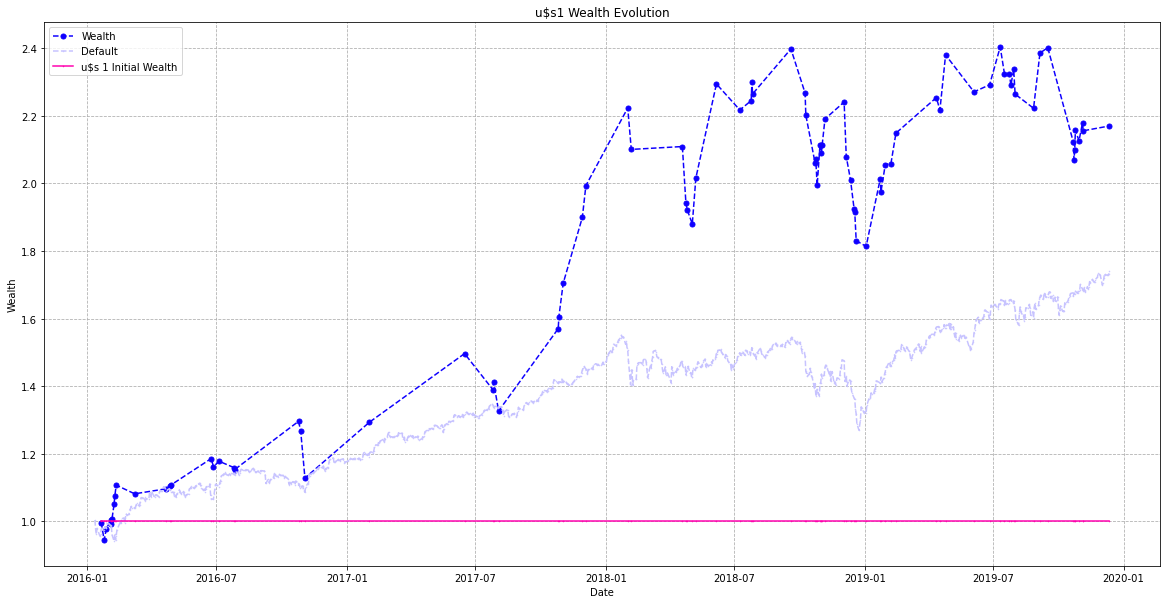

In [36]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('u$s1 Wealth Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Wealth')
ax.plot(discount_factor.index, discount_factor.values, marker='.', color='#0F00FF', markersize=10, linestyle='--', label='Wealth')
ax.plot(market_discount_factor.index, market_discount_factor.values, marker='.', color='#C7C3FF', markersize=1, linestyle='--', label='Default')
ax.plot(discount_factor.index, np.ones(discount_factor.shape), marker='.', color='#FF00AE', markersize=1, linestyle='-', label='u$s 1 Initial Wealth')
ax.legend()

In [37]:
portfolio_positions.to_csv('machinelearning_trading.csv')

-----

In [38]:
tickers = yf.Ticker("^GSPC")

sp500 = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
sp500 = sp500.loc[:,['Adj Close']]
sp500.head()

,Adj Close
Date,
2016-01-11 00:00:00-05:00,1923.670044
2016-01-12 00:00:00-05:00,1938.680054
2016-01-13 00:00:00-05:00,1890.280029
2016-01-14 00:00:00-05:00,1921.839966
2016-01-15 00:00:00-05:00,1880.329956


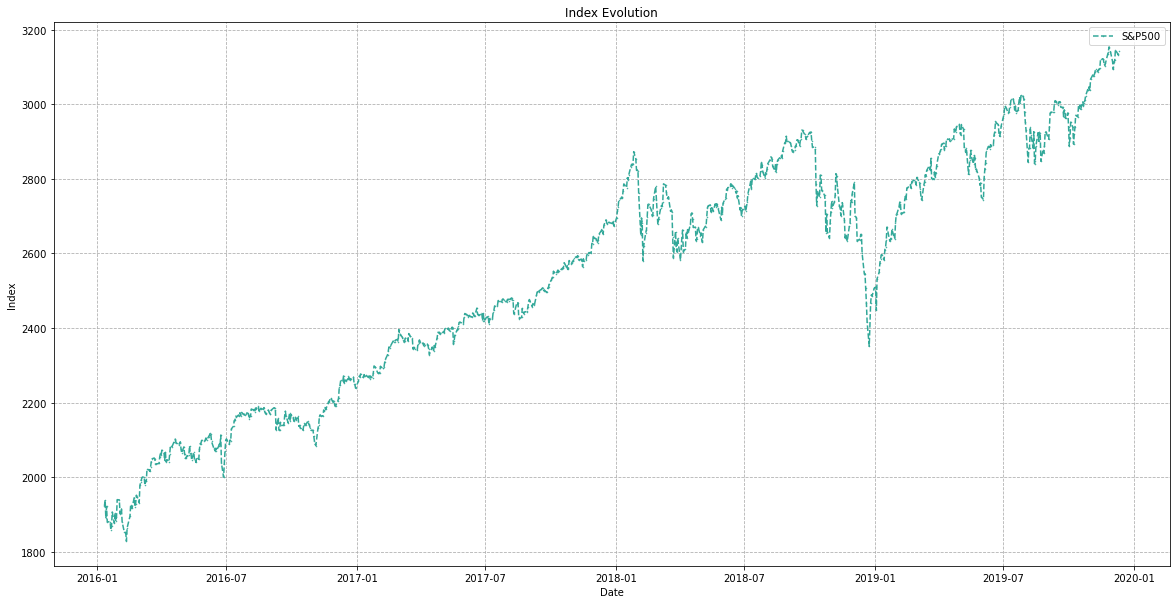

In [39]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('Index Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
ax.plot(sp500.index, sp500.loc[:,'Adj Close'].values, marker='.', color='#32A899', markersize=1, linestyle='--', label='S&P500')
ax.legend()